# Machine Learning for Data Analysis
# Assignment: Running a Random Forest

Following is the Python program I wrote to fulfill the third assignment of the [Machine Learning for Data Analysis online course](https://www.coursera.org/learn/machine-learning-data-analysis/home/welcome).

I decided to use [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

## Assignment research question

Using the [Gapminder database](http://www.gapminder.org/), I would like to see the variables that are the most influencing the income per person (2010 GDP per capita in constant 2000 US$) from the following list of variables:

- Residential electricity consumption (per person in kWh)
- CO2 emissions (in metric tons)
- Employ rate (total employees age 15+ in % of the population)
- Internet use rate (Internet users per 100 people)
- Life expectancy (Life expectancy at birth in years)
- Polity score (Democracty score; the scale ranges from -10 (the lowest) to 10 (the highest))
- Urban rate (Urban population in %)


## Data management

For the question I'm interested in, the countries for which data are missing will be discarded. As missing data in Gapminder database are replaced directly by `NaN` no special data treatment is needed.

In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV

In [2]:
# Read the data
data_filename = r'gapminder.csv'
data = pd.read_csv(data_filename)
data = data.set_index('country')

General information on the Gapminder data

In [3]:
display(Markdown("Number of countries: {}".format(len(data))))

Number of countries: 213

## Predictors selections and standardization

In [4]:
explanatory_vars = ['employrate', 'urbanrate', 'polityscore', 'lifeexpectancy', 'internetuserate', 'relectricperperson']
response_var = 'incomeperperson'

constructor_dict = dict()
for var in explanatory_vars + [response_var, ]:
    constructor_dict[var] = pd.to_numeric(data[var], errors='coerce')

numeric_data = pd.DataFrame(constructor_dict, index=data.index).dropna()

display(Markdown("Number of countries after discarding countries with missing data: {}".format(len(numeric_data))))

Number of countries after discarding countries with missing data: 122

The number of countries has unfortunately been almost divided by two due to missing data. Nevertheless the k-fold cross-validation technique will be used.

In [5]:
predictors = numeric_data[explanatory_vars]

target = numeric_data[response_var]

# Standardize predictors to have mean=0 and std=1
from sklearn import preprocessing
std_predictors = predictors.copy()

for var in std_predictors.columns:
    std_predictors[var] = preprocessing.scale(std_predictors[var].astype('float64'))
    
# Check standardization
std_predictors.describe()

,employrate,urbanrate,polityscore,lifeexpectancy,internetuserate,relectricperperson
count,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02
mean,2.966662e-16,-1.255826e-16,-7.280151e-18,6.151728e-16,-1.674435e-16,3.458072e-17
std,1.004124e+00,1.004124e+00,1.004124e+00,1.004124e+00,1.004124e+00,1.004124e+00
min,-2.213732e+00,-2.320113e+00,-2.276661e+00,-2.662916e+00,-1.374107e+00,-6.952002e-01
25%,-7.111398e-01,-6.144084e-01,-6.913150e-01,-4.067152e-01,-9.480402e-01,-5.613602e-01
50%,5.781782e-02,1.349639e-01,4.184275e-01,2.442529e-01,-8.308699e-02,-3.570663e-01
75%,5.686445e-01,6.746787e-01,8.543977e-01,7.129940e-01,8.859429e-01,1.949836e-01
max,2.492397e+00,1.935811e+00,8.940314e-01,1.394599e+00,2.020079e+00,6.239523e+00


The table above proves the explanatory variables have been standardized (i.e. mean=0 and std=1).

Next the data will be split in two sets; the training set (70% of the data) and the test set (30% of the data). Then the lasso regression analysis will be carried out with 10 folds in the k-fold cross-validation process.

In [6]:
# split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(std_predictors, target, 
                                                              test_size=.3, random_state=123)

# specify the lasso regression model
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)

# print variable names and regression coefficients
pd.Series(model.coef_, index=explanatory_vars, name='Regression coefficients').to_frame()

,Regression coefficients
employrate,0.000000
urbanrate,0.000000
polityscore,591.101333
lifeexpectancy,181.624969
internetuserate,4999.326773
relectricperperson,2774.715039


From the lasso regression, the *employ rate* and the *urban rate* have been discarded of the explanatory variables list. Then the most influential variables are in order :

1. Internet use rate
1. Residential electric consumption per person
1. Polity score
1. Life expectancy

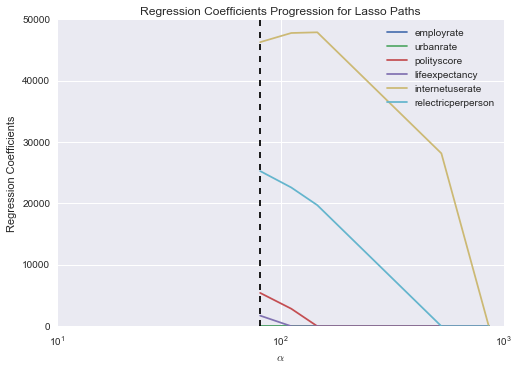

In [7]:
# plot coefficient progression
plt.semilogx(model.alphas_, model.coef_path_.T)
plt.legend(explanatory_vars)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel(r'$\alpha$')
plt.title('Regression Coefficients Progression for Lasso Paths');

The plot above showing the evolution of the regression coefficient proves the order of appearance of the four remaining explanatory variables; the *internet use rate* starting right from the beginning as it is the most infuential.

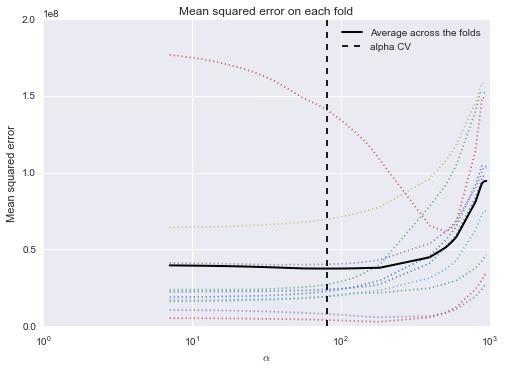

In [8]:
# plot mean square error for each fold
plt.semilogx(model.cv_alphas_, model.cv_mse_path_, ':')
plt.semilogx(model.cv_alphas_, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold');         

Unexpectedly one fold have a rising error with the lasso regression analysis progression. A country may have an unusual combination of parameters explaining it.

In [9]:
# MSE from training and test data
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))

In [10]:
# R-square from training and test data
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)

In [11]:
pd.DataFrame({'MSE' : [train_error, test_error], 'R-square' : [rsquared_train, rsquared_test]},
             index=['Training data', 'Test data'])

,MSE,R-square
Training data,2.588138e+07,0.724049
Test data,4.932894e+07,0.650509


# Conclusion

The lasso regression has discarded two of the six explanatory variables tested here.

The accuracy given by R-square is 72% on the training data but 65% on the test data. This means that the model may be slightly overfitted.